In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.copy("/content/drive/MyDrive/AI_Datasets/BW_DB.zip", "/content")

'/content/BW_DB.zip'

In [3]:
%cd /content

/content


In [4]:
import os

In [5]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [6]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import glob
import torch.optim as optim
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torchvision.datasets as datasets
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
%matplotlib inline

# Constant Declaration

In [29]:
PATH = '/content/BW_DB/'
IMAGE_DIM=224
BATCH_SIZE = 32
VAL_SPLIT = 0.1
N_CLASSES = 6
NUM_EPOCHS = 50
print(os.listdir(PATH+'train'))

['angry', 'happy', 'sad', 'surprise', 'fear', 'neutral']


In [30]:
def load_data(path, val_split, batch_size):
    
    transform_dict = {
                    'src': transforms.Compose([
                        transforms.Grayscale(3),
                        transforms.Resize(IMAGE_DIM),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]),
     ])}

    train_data = datasets.ImageFolder(root=path+'train', transform=transform_dict['src'])
    test_data = datasets.ImageFolder(root=path+'test', transform=transform_dict['src'])
    dataset_size = len(train_data)

    #divided test into tst and validation
    train_size = int((1- val_split) * dataset_size)
    val_size = int(val_split * dataset_size)
  
    train_data, val_data = td.random_split(train_data, [train_size, val_size])
    
    data_loader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_test  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_val  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)

    return data_loader_train, data_loader_test, data_loader_val

## Sample Image Plotting 

(48, 48)


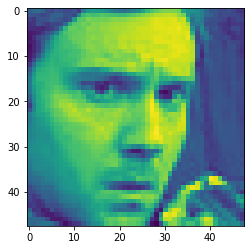

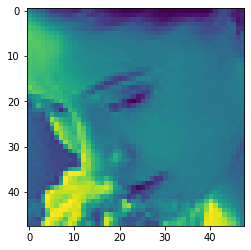

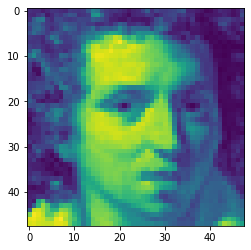

In [31]:
angerImage = matplotlib.image.imread(PATH+"/train/angry/0.jpg")
plt.figure()
plt.imshow(angerImage)
print(angerImage.shape)
fearImage =  matplotlib.image.imread(PATH+"/train/fear/10010.jpg")
plt.figure()
plt.imshow(fearImage)
happyImage =  matplotlib.image.imread(PATH+"/train/neutral/1000.jpg")
plt.figure()
plt.imshow(happyImage)

# Train and Test Loader

In [32]:
train_loader, test_loader, val_loader = load_data(PATH, VAL_SPLIT, BATCH_SIZE)
print("Train loader size: ",len(train_loader))
print("Test loader size: ", len(test_loader))
print("Val loader size: ", len(val_loader))

Train loader size:  254
Test loader size:  44
Val loader size:  29


# Random Images From Train Loader

torch.Size([32, 3, 224, 224])


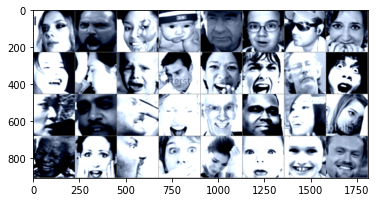

happy surprise happy  fear   sad angry  fear neutral happy neutral   sad neutral angry neutral   sad angry surprise  fear   sad neutral happy  fear happy  fear happy angry   sad angry surprise neutral happy happy


In [18]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('sad', 'neutral', 'happy', 'fear', 'surprise', 'angry')

#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
#Show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

# Pre Trained AlexNet Model Definition

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Device: cuda:0


# Model Structure

In [20]:
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# AlexNet using Transfer Learning

In [21]:
 # Updating the second classifier
model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 3 output nodes if we are going to get 3 class labels through our model.
model.classifier[6] = nn.Linear(1024,6)

model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Criterion and Optimizer Definition

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


# Model Training

In [34]:
def evaluate(model, test_loader):
  model.eval() 
  with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      labels=torch.flatten(labels)
      outputs = model(images)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = (correct / total) * 100
  model.train()
  return accuracy, loss.item()

In [ ]:
total_steps = len(train_loader)
t1 = time.time()

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            val_accu , val_loss = evaluate(model, test_loader)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, val_loss: {:.4f}, val_accuracy: {:.2f}%'
            .format(epoch + 1, NUM_EPOCHS, i + 1, total_steps, loss.item(),(correct / total) * 100, val_loss, val_accu))

            training_loss.append(loss.item())
            training_accuracy.append((correct / total) * 100)
            validation_accuracy.append(val_accu)
            validation_loss.append(val_loss)
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

# Save Model

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/AI_Datasets/AlexNet_BW_PreTrained.pt")

# Load Model

In [39]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet')

 # Updating the second classifier
model.classifier[4] = nn.Linear(4096,1024)

#Updating the third and the last classifier that is the output layer of the network. Make sure to have 3 output nodes if we are going to get 3 class labels through our model.
model.classifier[6] = nn.Linear(1024,6)

model.load_state_dict(torch.load('/content/drive/MyDrive/AI_Datasets/AlexNet_BW_PreTrained.pt'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Device: cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Model Testing

In [40]:
model.eval() 
with torch.no_grad(): 
  correct = 0
  total = 0
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    labels=torch.flatten(labels)
    outputs = model(images)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print((correct / total) * 100)

61.0352264557872


# Loss Plot

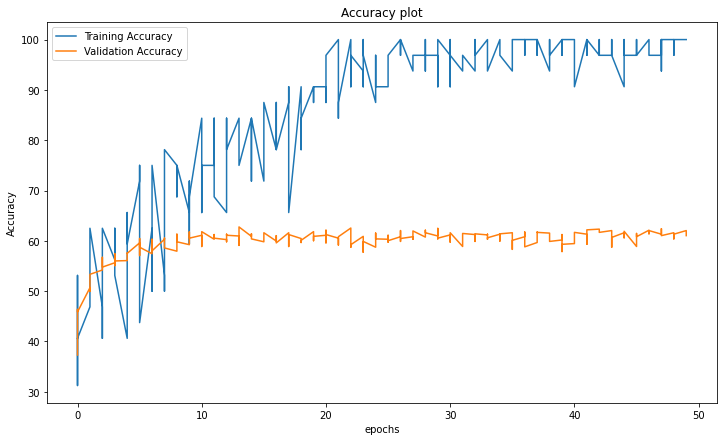

In [ ]:
epochs = [i//5 for i in range(NUM_EPOCHS*5)]
plt.figure(figsize = (12,7))
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

plt.plot(epochs,training_accuracy,label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')    
plt.legend()

plt.savefig('Accuracy_AlexNet_BW_PreTrained.png')

# Accuracy Plot

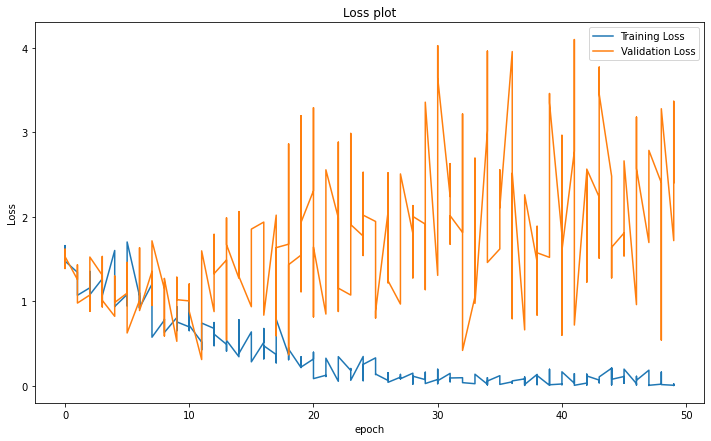

In [ ]:
epochs = [i//5 for i in range(NUM_EPOCHS*5)]
plt.figure(figsize = (12,7))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(epochs,training_loss,label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')    
plt.legend()
plt.savefig('Loss_AlexNet_BW_PreTrained.png')

# Confusion Matrix

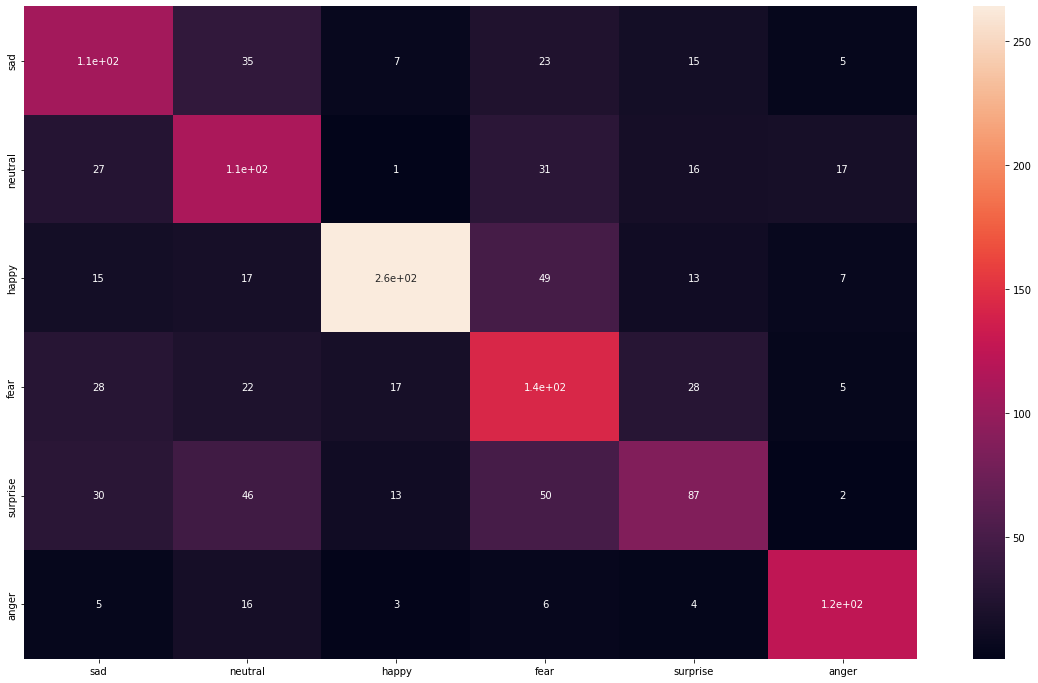

In [ ]:
y_pred = []
y_true = []

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import seaborn as sns

for i, data in enumerate(test_loader):
  images, labels = data[0].to(device), data[1].to(device)
  output = model(images) # Feed Network

  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output) # Save Prediction
  
  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # Save Truth

# constant for classes
classes = ('sad', 'neutral', 'happy', 'fear', 'surprise', 'anger')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)



# sns.heatmap(cf_matrix, annot=True)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20, 12))
sn.heatmap(df_cm, annot=True)
plt.savefig('Confusion_matrix_AlexNet_BW_PreTrained.png')

## T-SNE Visualisation

In [41]:
#TSNE
#['angry', 'happy', 'sad', 'surprise', 'fear', 'neutral']
face_map = {0:'angry', 1:'happy', 2:'sad', 3:'surprise', 4:'fear', 5:'neutral'}
model.eval()
targets_list = []
outputs_list = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_np = targets.data.cpu().numpy()

        outputs = model(inputs)
        outputs_np = outputs.data.cpu().numpy()

        targets_list.append(targets_np[:, np.newaxis])
        outputs_list.append(outputs_np)

targets = np.concatenate(targets_list, axis=0)
outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

print(len(targets))
print(len(outputs))

8100
8100


generating t-SNE plot...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[0]
 [3]
 [4]
 ...
 [1]
 [4]
 [5]]
              x          y   targets
0    -19.081573  72.395775     angry
1    -73.204704 -17.062012  surprise
2     25.736406  22.834116      fear
3     13.237307 -50.173527       sad
4     -8.086165  51.033745     angry
...         ...        ...       ...
8095 -12.041665  67.546997     angry
8096  52.005299  56.851196      fear
8097  -7.456494 -18.346472     happy
8098  59.970924  42.919010      fear
8099  76.411018 -32.897213   neutral

[8100 rows x 3 columns]
done!


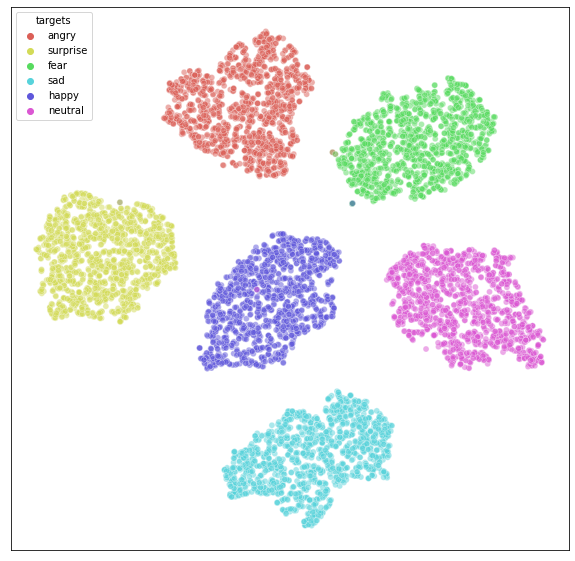

In [43]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
print('generating t-SNE plot...')
# tsne_output = bh_sne(outputs)
tsne = TSNE(random_state=0)
tsne_output = tsne.fit_transform(outputs)

df = pd.DataFrame(tsne_output, columns=['x', 'y'])
df.insert(2, 'targets', targets, True)
df.loc[:, 'targets'] = df.targets.map(face_map)

print(targets)
print(df)

plt.rcParams['figure.figsize'] = 10, 10
sns.scatterplot(
    x='x', y='y',
    hue='targets',
    palette=sns.color_palette("hls", 6),
    data=df,
    marker='o',
    legend="full",
    alpha=0.5
)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# plt.savefig(os.path.join(save_dir,'tsne.png'), bbox_inches='tight')
print('done!')
plt.savefig('TSNE_Alex_BW_Pretrained.png')